In [241]:
import pandas as pd
import ir_datasets as irds
from ir_measures import read_trec_qrels
from ir_measures import * 
from ir_measures import evaluator
import pyterrier as pt
from scipy.stats import ttest_ind
import os
from os import path as path

In [242]:
!pip install seaborn 
!pip install matplotlib

# Data Ingestion

In [243]:
DIR = '../..' # if this breaks replace with a full path to the repo

DATASET = "msmarco-passage/trec-dl-2019/judged"
qrel_directory = f'{DIR}/judgments/main/qrels/'
annotation_directory = f'{DIR}/judgments/main/doccano/'

In [244]:
dataset = irds.load(DATASET)
original_qrels = pd.DataFrame(dataset.qrels_iter())

In [245]:
all_qrels = []
for file in os.listdir(qrel_directory):
    print(file)
    if file.endswith('.txt'):
        qrels = pd.DataFrame(read_trec_qrels(qrel_directory + file))
        annotator = file.replace('.txt', '').replace('-qrels', '')
        qrels['annotator'] = annotator
        all_qrels.append(qrels)

all_qrels = pd.concat(all_qrels)

saber-zerhoudi-qrels.txt
froebe-qrels.txt
harry-scells-qrels.txt
ferdinand-schlatt-qrels.txt
guglielmo-faggioli-qrels.txt
sean-macavaney-qrels.txt
andrew-parry-qrels.txt
eugene-yang-qrels.txt


In [246]:
all_comments = []
for file in os.listdir(annotation_directory):
    if file.endswith('.jsonl'):
        comments = pd.read_json(annotation_directory + file, lines=True)
        annotator = file.replace('.jsonl', '')
        comments['annotator'] = annotator
        # filter in case that comments 'Comments' column is an empty list
        comments = comments[comments['Comments'].apply(lambda x: len(x) > 0)]
        all_comments.append(comments)

all_comments = pd.concat(all_comments)[['text', 'annotator', 'label', 'Comments']]
all_comments['label'] = all_comments['label'].apply(lambda x: x[0])

In [247]:
RUN_DIR = f'{DIR}/runs/trec-dl-2019'
BM25_TUNED = 'dl-19-official-input.bm25tuned_p.gz'
BM25_BASE = 'dl-19-official-input.bm25base_p.gz'
SET_ENCODER_COLBERT = 'colbert_monoelectra-base_msmarco-passage-trec-dl-2019-judged.run'
COLBERT = 'maik-froebe-colbert-run.txt'
SPLADE = 'maik-froebe-splade-run.txt'
RANK_ZEPHYR = 'maik-froebe-rank-zephyr-run.txt'

In [248]:
BM25_TUNED_RUN = pt.io.read_results(path.join(RUN_DIR, BM25_TUNED)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
BM25_BASE_RUN = pt.io.read_results(path.join(RUN_DIR, BM25_BASE)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
SET_ENCODER_COLBERT_RUN = pt.io.read_results(path.join(RUN_DIR, SET_ENCODER_COLBERT)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
COLBERT_RUN = pt.io.read_results(path.join(RUN_DIR, COLBERT)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
SPLADE_RUN = pt.io.read_results(path.join(RUN_DIR, SPLADE)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
RANK_ZEPHYR_RUN = pt.io.read_results(path.join(RUN_DIR, RANK_ZEPHYR)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})

runs = {
    'bm25_tuned': BM25_TUNED_RUN,
    'bm25_base': BM25_BASE_RUN,
    'set_encoder_colbert': SET_ENCODER_COLBERT_RUN,
    'colbert': COLBERT_RUN,
    'splade': SPLADE_RUN,
    'rank_zephyr': RANK_ZEPHYR_RUN
}

# Effectiveness

In [249]:
metrics = [AP(rel=2), NDCG(cutoff=10), R(rel=2)@100, P(rel=2, cutoff=10), RR(rel=2), RR(rel=2, cutoff=10)]

In [250]:
original_evaluator = evaluator(metrics, qrels=original_qrels)

In [251]:
import numpy as np

def convert_qrels(qrels, shuffle_grades=False, seed=None):
    # Set the random seed if provided, or generate a random seed dynamically
    rng = np.random.default_rng(seed)

    # Step 1: Sort by query_id and relevance to ensure correct ranking order
    qrels = qrels.sort_values(by=['query_id', 'relevance'], ascending=[True, False])

    # Step 2: Shuffle within each relevance group for each query, if shuffle_grades=True
    if shuffle_grades:
        shuffled_qrels = []
        for query_id, group in qrels.groupby('query_id'):
            # For each query, process relevance levels
            group_shuffled = []
            for relevance_level, relevance_group in group.groupby('relevance'):
                # Shuffle rows within each relevance level, using the seed for reproducibility
                shuffled_group = relevance_group.sample(frac=1, random_state=rng.integers(1e9))
                group_shuffled.append(shuffled_group)

            # Combine shuffled relevance groups for the query, preserving relevance order
            shuffled_qrels.append(pd.concat(group_shuffled))

        # Concatenate all queries back into a single DataFrame
        qrels = pd.concat(shuffled_qrels).reset_index(drop=True)

    # Step 3: Assign a score based on the **sorted relevance**, independent of shuffling
    qrels['score'] = qrels.groupby('query_id').cumcount(ascending=True) + 1

    return qrels


In [252]:
annotator_out = []
for annotator, qrels in all_qrels.groupby('annotator'):
    annotator_evaluator = evaluator(metrics, qrels=qrels)
    relevant_queries = qrels['query_id'].unique()
    query_set = list(relevant_queries)
    rez = convert_qrels(qrels)
    measures = original_evaluator.calc_aggregate(rez)
    measures = {str(k): v for k, v in measures.items()}
    measures['annotator'] = annotator
    measures['run'] = 'annotator'
    measures['type'] = 'official'
    measures['queries'] = query_set
    annotator_out.append(measures)

    for run_name, run in runs.items():
        run = run[run['query_id'].isin(relevant_queries)]
        run_measures = original_evaluator.calc_aggregate(run)
        run_measures = {str(k): v for k, v in run_measures.items()}
        run_measures['annotator'] = annotator
        run_measures['run'] = run_name
        run_measures['type'] = 'official'
        run_measures['queries'] = query_set
        annotator_out.append(run_measures)

        run_measures = annotator_evaluator.calc_aggregate(run)
        run_measures = {str(k): v for k, v in run_measures.items()}
        run_measures['annotator'] = annotator
        run_measures['run'] = run_name
        run_measures['type'] = 'annotator'
        run_measures['queries'] = query_set
        annotator_out.append(run_measures)


annotator_out = pd.DataFrame(annotator_out)

In [253]:
annotator_out

,RR(rel=2),P(rel=2)@10,R(rel=2)@100,nDCG@10,RR(rel=2)@10,AP(rel=2),annotator,run,type,queries
0,0.029512,0.039535,0.244078,0.034834,0.028618,0.093760,andrew-parry,annotator,official,"[855410, 146187, 130510, 1110199, 490595, 5737..."
1,0.268217,0.139535,0.165347,0.173879,0.268217,0.118552,andrew-parry,bm25_tuned,official,"[855410, 146187, 130510, 1110199, 490595, 5737..."
2,0.477137,0.223077,0.535538,0.344164,0.473932,0.242412,andrew-parry,bm25_tuned,annotator,"[855410, 146187, 130510, 1110199, 490595, 5737..."
3,0.266279,0.139535,0.162255,0.175449,0.266279,0.117299,andrew-parry,bm25_base,official,"[855410, 146187, 130510, 1110199, 490595, 5737..."
4,0.458275,0.269231,0.549753,0.374594,0.451282,0.254570,andrew-parry,bm25_base,annotator,"[855410, 146187, 130510, 1110199, 490595, 5737..."
...,...,...,...,...,...,...,...,...,...,...
99,0.626094,0.306667,0.574544,0.513298,0.624074,0.311839,sean-macavaney,colbert,annotator,"[405717, 182539, 131843, 1113437, 443396, 1117..."
100,0.290698,0.158140,0.181022,0.219697,0.290698,0.120823,sean-macavaney,splade,official,"[405717, 182539, 131843, 1113437, 443396, 1117..."
101,0.669444,0.333333,0.606484,0.539445,0.666667,0.331608,sean-macavaney,splade,annotator,"[405717, 182539, 131843, 1113437, 443396, 1117..."
102,0.252713,0.172093,0.161547,0.218379,0.252713,0.110299,sean-macavaney,rank_zephyr,official,"[405717, 182539, 131843, 1113437, 443396, 1117..."


In [254]:
annotator_out['query_tuple'] = annotator_out['queries'].apply(tuple)
unique_queries = {tuple_queries: idx for idx, tuple_queries in enumerate(annotator_out['query_tuple'].unique())}
annotator_out['query_idx'] = annotator_out['query_tuple'].apply(lambda x: unique_queries[x])

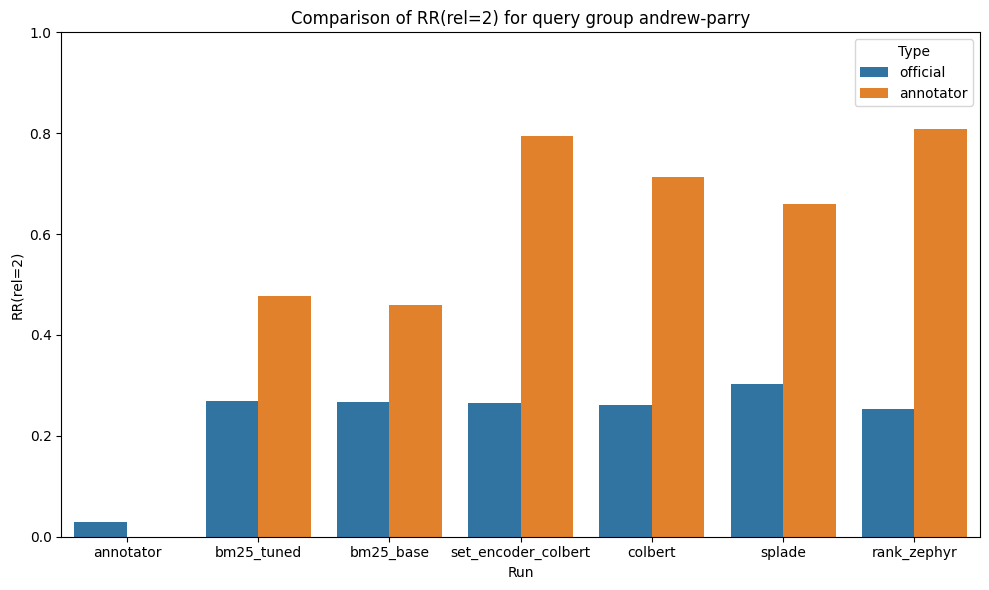

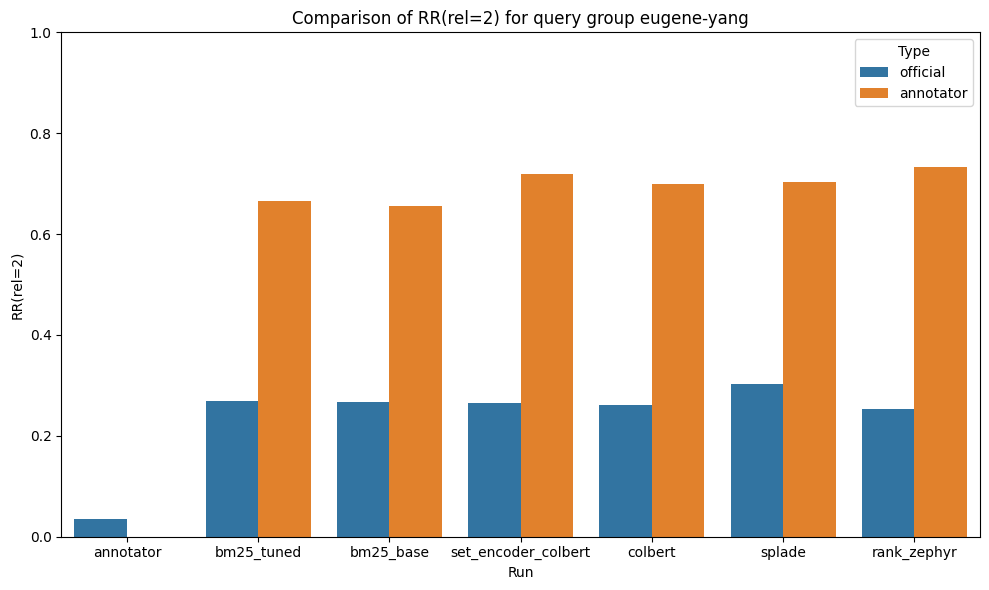

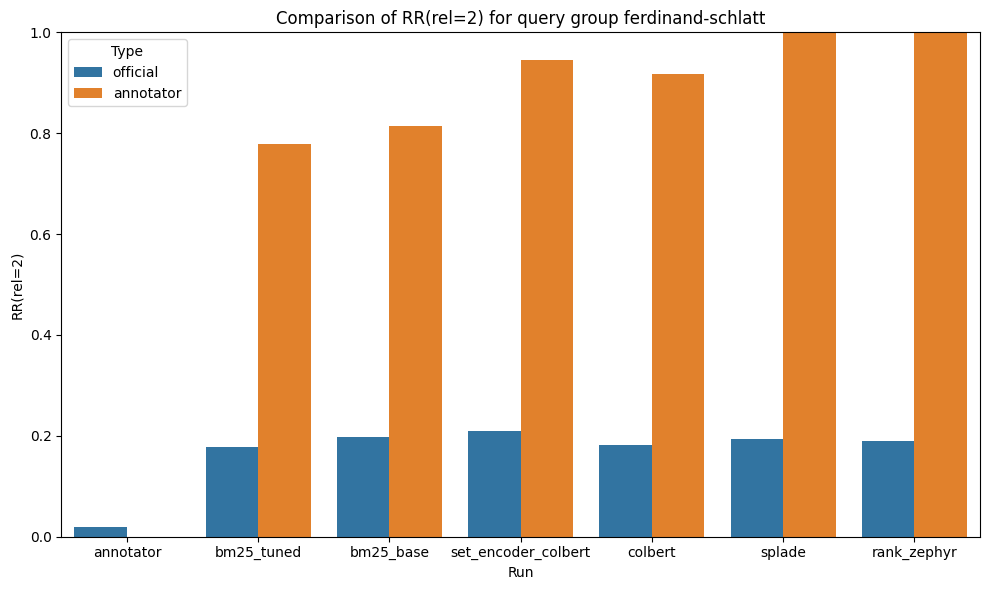

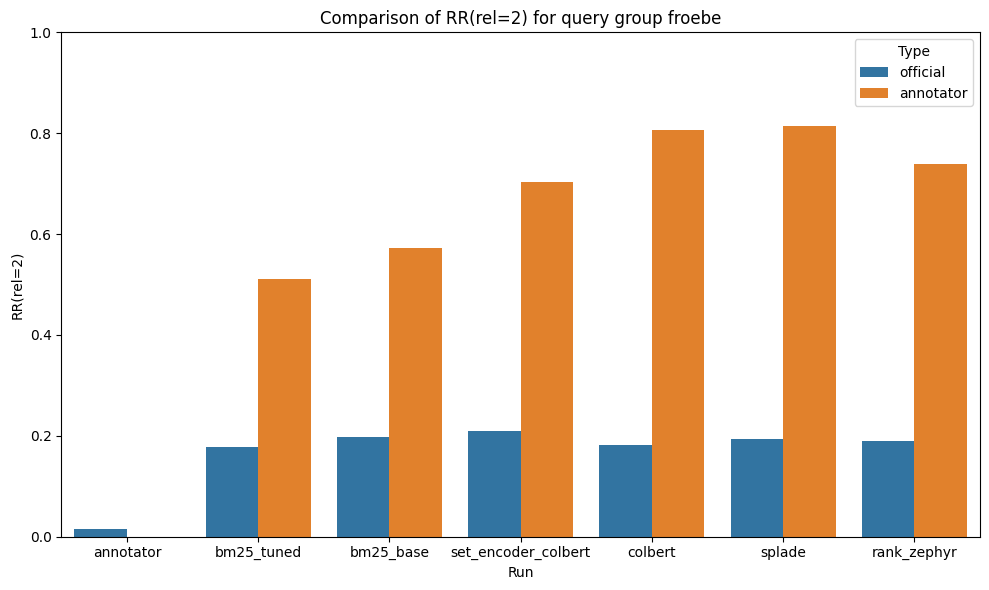

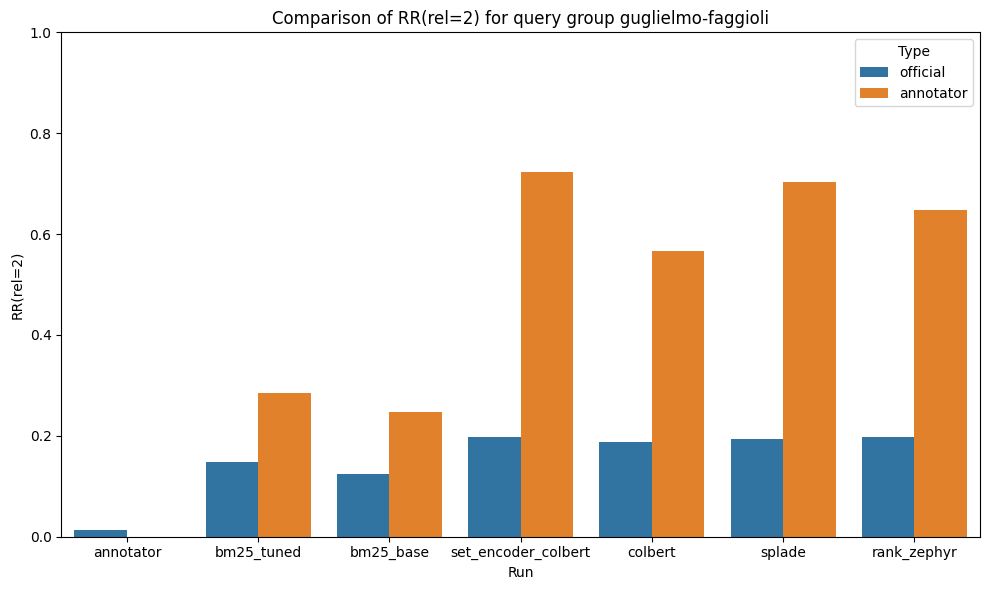

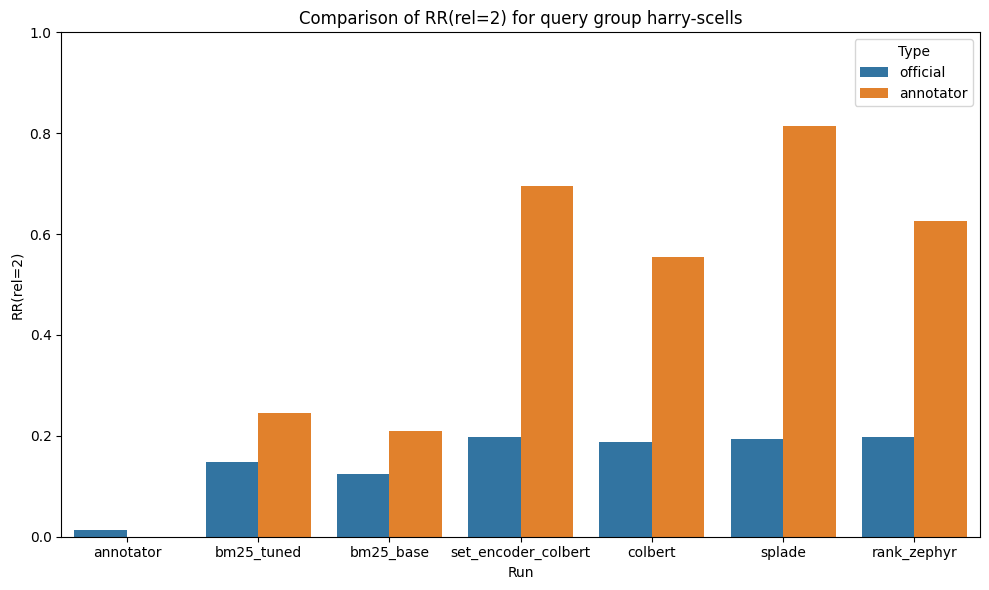

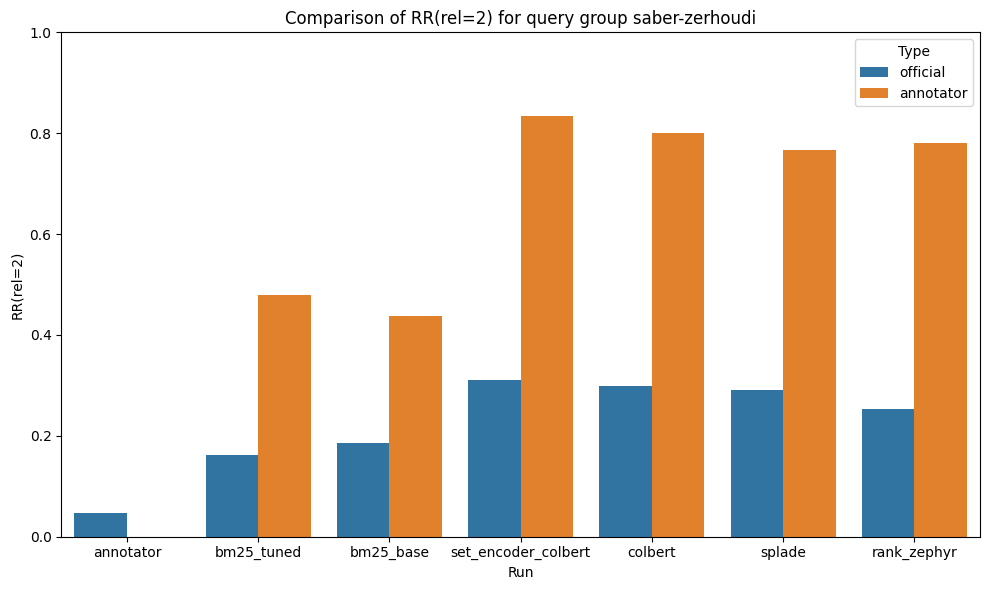

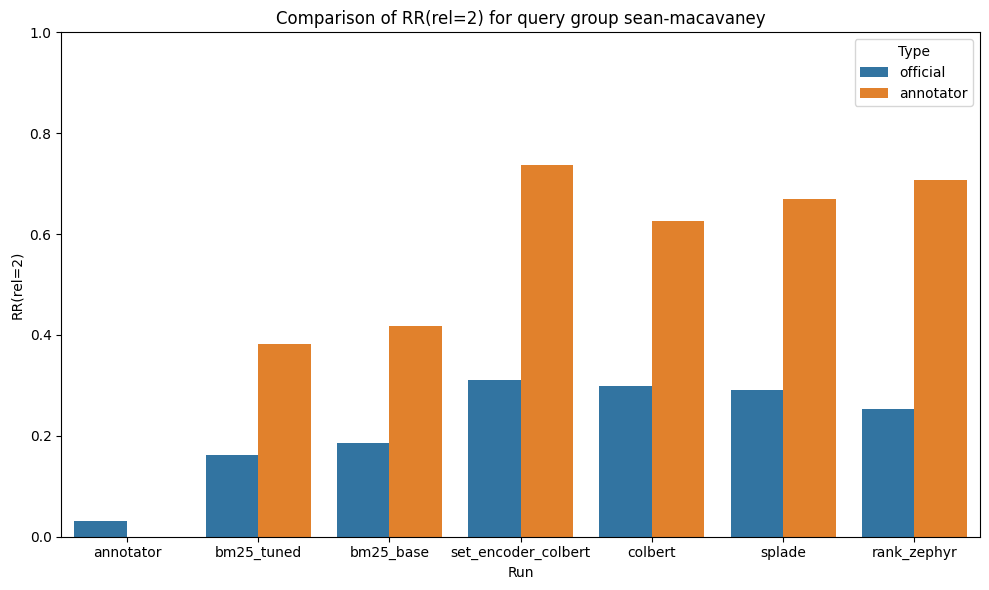

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric_by_type(df, metric):
    unique_groups = df['annotator'].unique()
    
    # Create a plot for each unique group of queries
    for group in unique_groups:
        subset = df[df['annotator'] == group]
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='run', y=metric, hue='type', data=subset)
        
        plt.title(f'Comparison of {metric} for query group {group}')
        plt.ylabel(metric)
        # y range 0 to 1
        plt.ylim(0, 1)
        plt.xlabel('Run')
        plt.legend(title='Type')
        plt.tight_layout()
        plt.show()

# Example: Plot 'RR(rel=2)'
plot_metric_by_type(annotator_out, 'RR(rel=2)')

## Oracles

In [256]:
max_qrels = all_qrels.groupby(['query_id', 'doc_id']).agg({'relevance': 'max'}).reset_index()
min_qrels = all_qrels.groupby(['query_id', 'doc_id']).agg({'relevance': 'min'}).reset_index()

In [257]:
max_run = convert_qrels(max_qrels)
min_run = convert_qrels(min_qrels)

In [258]:
print(original_evaluator.calc_aggregate(max_run))
print(original_evaluator.calc_aggregate(min_run))

{RR(rel=2): 0.319002235860901, P(rel=2)@10: 0.20465116279069764, R(rel=2)@100: 0.825612590619421, nDCG@10: 0.3252040045036922, RR(rel=2)@10: 0.2970099667774086, AP(rel=2): 0.3621737633603794}
{RR(rel=2): 0.5142099478588786, P(rel=2)@10: 0.3139534883720931, R(rel=2)@100: 0.8382103441160637, nDCG@10: 0.4593972531378782, RR(rel=2)@10: 0.5107235142118863, AP(rel=2): 0.41413126488429913}


In [260]:
NUM_SAMPLES = 10
random_iters = []
for i in range(10):
    max_run = convert_qrels(max_qrels, shuffle_grades=True, seed=i)
    max_measures = original_evaluator.calc_aggregate(max_run)
    max_measures = {str(k): v for k, v in max_measures.items()}
    max_measures['run'] = 'max'
    max_measures['iter'] = i
    min_run = convert_qrels(min_qrels, shuffle_grades=True, seed=i)
    min_measures = original_evaluator.calc_aggregate(min_run)
    min_measures = {str(k): v for k, v in min_measures.items()}
    min_measures['run'] = 'min'
    min_measures['iter'] = i
    random_iters.append(max_measures)
    random_iters.append(min_measures)

random_iters = pd.DataFrame(random_iters)

In [261]:
random_iters.groupby('run').mean()

,RR(rel=2),P(rel=2)@10,R(rel=2)@100,nDCG@10,RR(rel=2)@10,AP(rel=2),iter
run,,,,,,,
max,0.843354,0.689070,0.888111,0.779101,0.842405,0.708250,4.5
min,0.859384,0.695116,0.882790,0.787459,0.859172,0.680226,4.5


In [262]:
random_iters

,RR(rel=2),P(rel=2)@10,R(rel=2)@100,nDCG@10,RR(rel=2)@10,AP(rel=2),run,iter
0,0.773044,0.695349,0.887075,0.763155,0.770930,0.700336,max,0
1,0.880814,0.695349,0.884606,0.794456,0.880814,0.673334,min,0
2,0.836739,0.702326,0.887318,0.783356,0.835078,0.709470,max,1
3,0.842636,0.695349,0.882786,0.790253,0.842636,0.688624,min,1
4,0.873514,0.695349,0.888572,0.788775,0.873514,0.711451,max,2
5,0.853295,0.690698,0.884874,0.778821,0.853295,0.678376,min,2
6,0.810188,0.665116,0.885493,0.766660,0.808527,0.697100,max,3
7,0.895349,0.693023,0.881026,0.793598,0.895349,0.681212,min,3
8,0.890956,0.700000,0.889487,0.792487,0.890956,0.709356,max,4
9,0.844767,0.695349,0.882333,0.781294,0.844767,0.673083,min,4


In [264]:
random_iters.groupby('run').var()

,RR(rel=2),P(rel=2)@10,R(rel=2)@100,nDCG@10,RR(rel=2)@10,AP(rel=2),iter
run,,,,,,,
max,0.001486,0.000164,0.000002,0.000083,0.001529,0.000030,9.166667
min,0.000336,0.000014,0.000003,0.000042,0.000338,0.000051,9.166667
